# **Image Classification with Convolutional Neural Networks (CNNs) using PyTorch**

In this Jupyter Notebook, we will dive into the essential ideas of **Convolutional Neural Networks (CNNs)** for image classification—building upon the concepts from the video: **"Neural Networks Part 8: Image Classification with Convolutional Neural Networks (CNNs)"** (StatQuest by Josh Starmer). We will:

- Learn about filters (convolution kernels) and how they help identify patterns in small, local regions of an image.
- Understand how **ReLU** activation functions and **Pooling** layers reduce the spatial size of the representation.
- See how CNNs can handle shifts in images and still recognize patterns.
- Build a simple CNN from scratch (using a small synthetic dataset of hand-drawn **X** and **O** images) and train it to classify the images using **PyTorch**.

We will also provide references to seminal papers in CNN and deep learning. 

---

## **Notebook Outline**
1. [Introduction to CNNs](#section1)
2. [Import Libraries](#section2)
3. [Create a Synthetic **X** / **O** Dataset](#section3)
4. [Data Visualization](#section4)
5. [Build and Train a Simple CNN](#section5)
6. [Evaluate the Model](#section6)
7. [Conclusion](#section7)
8. [References](#section8)


## 1. Introduction to CNNs

Convolutional Neural Networks (CNNs) are specialized architectures for processing data with a known, grid-like topology (e.g., images). Their key innovations are:

1. **Convolutional Layers**: A filter (or kernel) slides across the image, computing a dot product between the filter weights and local regions of the image (a process called "convolution"). This exploits **local connectivity** and greatly reduces the number of parameters compared to a fully-connected network.

$$\text{Output}[i, j] = \sum_{m,n} \Big(\text{Filter}[m,n] \times \text{Input}[i+m, j+n]\Big) + b$$

2. **Activation Functions** (often **ReLU**):

$$\text{ReLU}(z) = \max(0, z)$$

   ReLU makes training faster and helps mitigate the **vanishing gradient** problem better than logistic or tanh activation.

3. **Pooling Layers**: They **reduce** the spatial dimension (e.g., 2x2 max-pooling) while retaining the most important feature responses. A typical pooling operator:

- **Max pooling**: $$\text{MaxPool}\big(\{x_1, x_2, ..., x_k\}\big) = \max(x_1, x_2, ..., x_k)$$

4. **Fully Connected Layers**: At the end of the convolutional stack, the feature maps are flattened and passed to one or more fully connected (dense) layers to perform classification or regression.

These concepts allow CNNs to:

- **Capture local correlations** in images.
- Be **translation-invariant** or robust to shifts in the image.
- Significantly **reduce** the number of trainable parameters.

---

## 2. Import Libraries

Here we import all the Python libraries that we will use in this tutorial.

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## 3. Create a Synthetic **X** / **O** Dataset

We will create a synthetic dataset of **6x6** grayscale images containing either an **X** or an **O**. We'll represent black pixels with 1 and white pixels with 0, similar to the discussion in the video. Each image will be stored as a 2D NumPy array and then converted to PyTorch tensors.

### 3.1 Helper Functions to Draw **X** and **O**

In [3]:
def draw_O(size=6):
    """Generate a 6x6 image with an O shape."""
    img = np.zeros((size, size), dtype=np.float32)
    # We'll draw an O in the boundary
    for i in range(size):
        for j in range(size):
            if i == 0 or i == size-1 or j == 0 or j == size-1:
                img[i, j] = 1.0
    return img

def draw_X(size=6):
    """Generate a 6x6 image with an X shape."""
    img = np.zeros((size, size), dtype=np.float32)
    for i in range(size):
        # X from top-left to bottom-right
        img[i, i] = 1.0
        # X from top-right to bottom-left
        img[i, size - i - 1] = 1.0
    return img

### 3.2 Generate Randomly Shifted **X** and **O** Images

To make the classification problem slightly more realistic, we will **randomly shift** each **X** and **O** by up to 1 pixel in any direction. This will test the CNN's ability to handle translations.

In [4]:
def random_shift(img, max_shift=1):
    """Shift the image up/down/left/right by up to max_shift pixels."""
    size = img.shape[0]
    shift_x = random.randint(-max_shift, max_shift)
    shift_y = random.randint(-max_shift, max_shift)

    shifted = np.zeros_like(img)
    for i in range(size):
        for j in range(size):
            new_i = i + shift_x
            new_j = j + shift_y
            if 0 <= new_i < size and 0 <= new_j < size:
                shifted[new_i, new_j] = img[i, j]
    return shifted

num_samples = 500  # Number of images per class
size = 6           # Image size 6x6

data = []
labels = []

# Label 0 for O, 1 for X
for _ in range(num_samples):
    o_img = draw_O(size)
    o_img_shifted = random_shift(o_img, max_shift=1)
    data.append(o_img_shifted)
    labels.append(0)

for _ in range(num_samples):
    x_img = draw_X(size)
    x_img_shifted = random_shift(x_img, max_shift=1)
    data.append(x_img_shifted)
    labels.append(1)

data = np.array(data)
labels = np.array(labels)

print("Data shape:", data.shape)
print("Labels shape:", labels.shape)

Data shape: (1000, 6, 6)
Labels shape: (1000,)


## 4. Data Visualization

Let's plot some samples from the dataset to see how the **X** and **O** appear (with small random shifts). We'll plot them in a grid with a color map that highlights the black vs. white pixels.

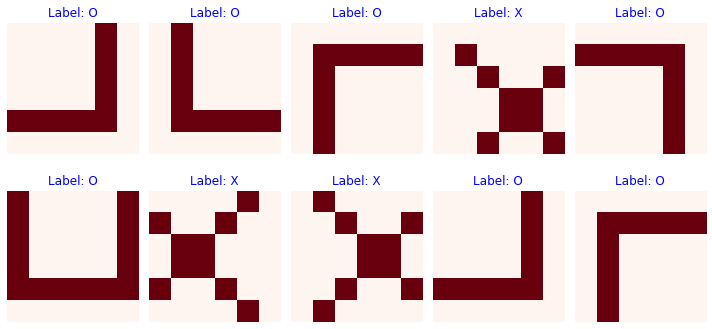

In [5]:
# Let's plot a few random examples
plt.figure(figsize=(10, 5))

for i in range(10):
    idx = random.randint(0, len(data)-1)
    plt.subplot(2, 5, i+1)
    plt.imshow(data[idx], cmap='Reds', vmin=0, vmax=1)
    label = "O" if labels[idx] == 0 else "X"
    plt.title(f"Label: {label}", color="blue")
    plt.axis('off')

plt.tight_layout()
plt.show()

### 4.1 Prepare Data for Training

We'll split the dataset into training and test sets using scikit-learn's `train_test_split`. We also need to convert everything into **PyTorch tensors**. Since these are grayscale images, we have only 1 channel.

Shape expected by a PyTorch CNN is typically `(batch_size, channels, height, width)`.

In [6]:
# Expand dims to (batch, 1, height, width)
data_expanded = np.expand_dims(data, axis=1).astype(np.float32)

# Train test split
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
    data_expanded, labels, test_size=0.2, random_state=42
)

print("Training data shape:", X_train_np.shape)
print("Testing data shape:\t", X_test_np.shape)

# Let's also note the dataset sizes
num_classes = 2  # O or X


Training data shape: (800, 1, 6, 6)
Testing data shape:	 (200, 1, 6, 6)


### 4.2 Build a Custom Dataset

We'll build a PyTorch `Dataset` for convenience, which can then be fed into a `DataLoader`. This will handle indexing and on-the-fly transformations if needed.

In [7]:
class XO_Dataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = torch.tensor(self.images[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return image, label

train_dataset = XO_Dataset(X_train_np, y_train_np)
test_dataset = XO_Dataset(X_test_np, y_test_np)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


## 5. Build and Train a Simple CNN

We will now build a CNN that resembles the logic explained in the video:

1. **Convolution** with a small filter (kernel) to detect local patterns.
2. **ReLU** activation to keep only positive values.
3. **Max Pooling** to reduce spatial size.
4. Flatten and connect to a fully connected layer for classification.

Our CNN architecture will be:
```
Input (1x6x6) --> Conv2D(4 filters, kernel_size=3) --> ReLU --> MaxPool2D(kernel_size=2)
--> Flatten --> Linear(2) --> Softmax
```

### 5.1 Define the Model

In [8]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2)
        # After conv1 (with kernel=3) on a 6x6 input, output size = 4x4, then maxpool => 2x2.
        # Number of features after flatten = 4 filters * (2*2) = 16.
        self.fc = nn.Linear(4 * 2 * 2, num_classes)

    def forward(self, x):
        x = self.conv1(x)       # shape: (batch, 4, 4, 4)
        x = F.relu(x)
        x = self.pool(x)        # shape: (batch, 4, 2, 2)
        x = x.view(x.size(0), -1)  # flatten => (batch, 16)
        x = self.fc(x)          # => (batch, 2)
        return x

### 5.2 Initialize Model, Define Loss and Optimizer

In [9]:
model = SimpleCNN(num_classes=2).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(model)

SimpleCNN(
  (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=16, out_features=2, bias=True)
)


### 5.3 Training Loop

We will train for a few epochs and keep track of the loss and accuracy on the training set. We can also track the validation accuracy by evaluating on the test set after each epoch if desired.

In [10]:
num_epochs = 10

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = 100.0 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Evaluate on test set
    model.eval()
    test_running_loss = 0.0
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)

    test_epoch_loss = test_running_loss / len(test_loader.dataset)
    test_epoch_acc = 100.0 * test_correct / test_total

    test_losses.append(test_epoch_loss)
    test_accuracies.append(test_epoch_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}% | "
          f"Test Loss: {test_epoch_loss:.4f}, Test Acc: {test_epoch_acc:.2f}%")

Epoch [1/10] - Train Loss: 0.6533, Train Acc: 85.62% | Test Loss: 0.6168, Test Acc: 100.00%
Epoch [2/10] - Train Loss: 0.5614, Train Acc: 100.00% | Test Loss: 0.4972, Test Acc: 100.00%
Epoch [3/10] - Train Loss: 0.4288, Train Acc: 100.00% | Test Loss: 0.3619, Test Acc: 100.00%
Epoch [4/10] - Train Loss: 0.3012, Train Acc: 100.00% | Test Loss: 0.2473, Test Acc: 100.00%
Epoch [5/10] - Train Loss: 0.2042, Train Acc: 100.00% | Test Loss: 0.1687, Test Acc: 100.00%
Epoch [6/10] - Train Loss: 0.1402, Train Acc: 100.00% | Test Loss: 0.1181, Test Acc: 100.00%
Epoch [7/10] - Train Loss: 0.0993, Train Acc: 100.00% | Test Loss: 0.0857, Test Acc: 100.00%
Epoch [8/10] - Train Loss: 0.0729, Train Acc: 100.00% | Test Loss: 0.0643, Test Acc: 100.00%
Epoch [9/10] - Train Loss: 0.0553, Train Acc: 100.00% | Test Loss: 0.0497, Test Acc: 100.00%
Epoch [10/10] - Train Loss: 0.0432, Train Acc: 100.00% | Test Loss: 0.0394, Test Acc: 100.00%


### 5.4 Plot Training and Validation History

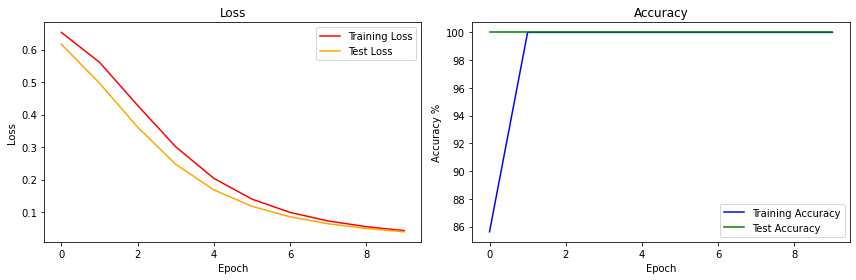

In [11]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='red')
plt.plot(test_losses, label='Test Loss', color='orange')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='blue')
plt.plot(test_accuracies, label='Test Accuracy', color='green')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy %')
plt.legend()

plt.tight_layout()
plt.show()

## 6. Evaluate the Model

We'll check our model's performance on the entire test set and display a quick **confusion matrix** to see how well it distinguishes **X** and **O**.

Final Test Accuracy = 100.00%


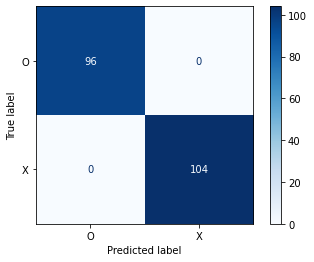

In [12]:
# Final evaluation on test set
model.eval()
test_correct = 0
test_total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

        # Store for confusion matrix
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = 100.0 * test_correct / test_total
print(f"Final Test Accuracy = {test_accuracy:.2f}%")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["O", "X"])
disp.plot(cmap=plt.cm.Blues)
plt.show()

## 7. Conclusion

In this notebook, we built a **Convolutional Neural Network (CNN)** to classify synthetic 6x6 images of **X** and **O** with small random shifts, but using **PyTorch** instead of other libraries. Here are the key takeaways:

- **Convolution** layers drastically reduce the number of parameters and exploit local spatial patterns.
- **Pooling** steps help the network become more robust to slight image translations.
- Even a small CNN can effectively learn to classify simple images.

These same basic principles extend to more complex tasks: the filters become more numerous and we use larger images, but the convolution + ReLU + pooling pattern remains the same.

---

## 8. References

1. **Neural Networks Part 8: Image Classification with CNNs** — [StatQuest by Josh Starmer](https://www.youtube.com/watch?v=HGwBXDKFk9I)
2. LeCun, Y., Bengio, Y., & Hinton, G. (2015). **Deep Learning**. *Nature*, 521, 436–444.
3. Rumelhart, D. E., Hinton, G. E., & Williams, R. J. (1986). **Learning representations by back-propagating errors**. *Nature*, 323, 533–536.
4. Krizhevsky, A., Sutskever, I., & Hinton, G. E. (2012). **ImageNet classification with deep convolutional neural networks**. *Advances in Neural Information Processing Systems*, 25, 1097–1105.
5. Goodfellow, I., Bengio, Y., & Courville, A. (2016). **Deep Learning**. MIT Press.

---
**Quest on!**